# Load Forecasting using Long Short-Term Memory (LSTM)


In [ ]:
#Import Library
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

plt.style.use('fivethirtyeight')

In [ ]:
#Pilih data PJME_hourly.csv
fpath='PJME_hourly.csv'

df = pd.read_csv(fpath, index_col='Datetime', parse_dates=['Datetime'])
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [ ]:
#Periksa Data nilai N/A
df.isna().sum()

PJME_MW    0
dtype: int64

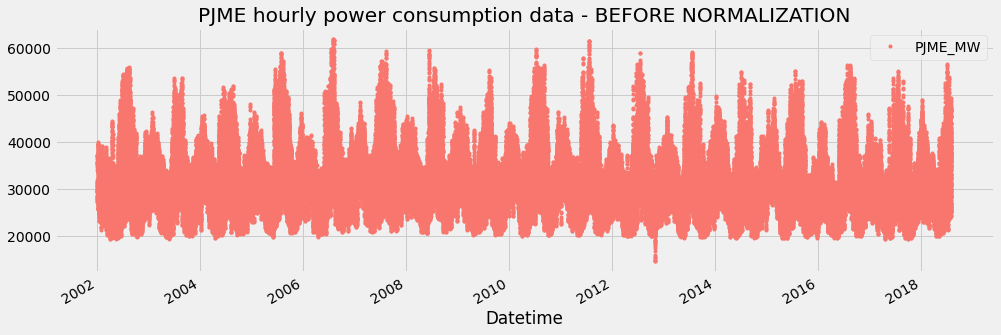

In [ ]:
#Plot data sebelum normalisasi
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]

df.plot(style='.', figsize=(15,5), color=color_pal[0], legend=True)
plt.title('PJME hourly power consumption data - BEFORE NORMALIZATION')
plt.show()

In [ ]:
#Normalisasi Data
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['PJME_MW']=scaler.fit_transform(df['PJME_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(145366, 1)

In [ ]:
#Pembagian Data
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[113927:]             
    y_test = y_train[113927:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:113927]           
    y_train = y_train[:113927]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    #4 reshape data to input 
    X_train = np.reshape(X_train, (113927, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [ ]:
#Membagi data train dan data test
seq_len = 24 #choose sequence length #20

X_train, y_train, X_test, y_test = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape  = ', X_test.shape)
print('y_test.shape  = ',y_test.shape)

X_train.shape =  (113927, 24, 1)
y_train.shape =  (113927,)
X_test.shape  =  (31415, 24, 1)
y_test.shape  =  (31415,)


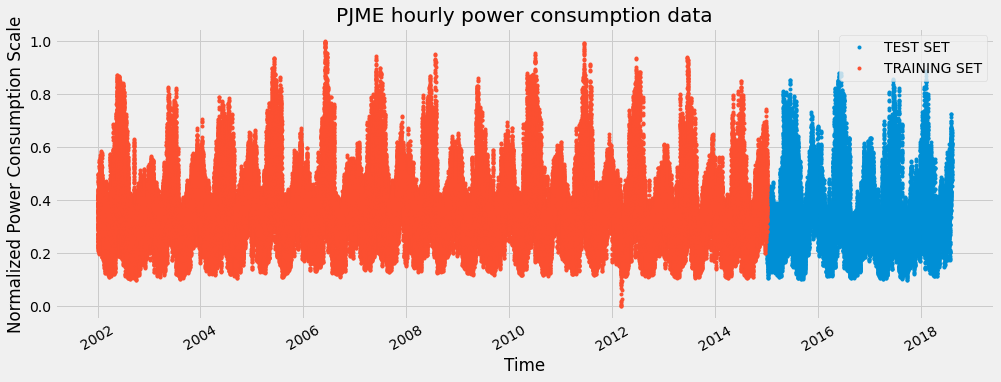

In [ ]:
#Plot Pembagian Data
x_data = range(145346)

plt.figure(figsize=(15,5))
plt.plot(x_data[113907+seq_len:], X_test[:,0], '.', label='TEST SET')
plt.plot(X_train[:,0], '.', label='TRAINING SET')
plt.xlabel('Time')
plt.ylabel('Normalized Power Consumption Scale')
x_ticks = np.arange(0, 145346, 17520)
plt.xticks(range(0, 145346, 17520), ['2002', '2004', '2006', '2008', '2010', '2012', '2014', '2016', '2018'], rotation=30)
plt.xticks(x_ticks)
plt.legend()
plt.title('PJME hourly power consumption data')
plt.show()

In [ ]:
# Buat model dan fit LSTM
model = Sequential()
model.add(LSTM(12, input_shape=(X_train.shape[1],1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=1, batch_size=2, verbose=2)

56964/56964 - 467s - loss: 7.8202e-04


In [ ]:
#Menentukan nilai prediksi
lstm_predictions = model.predict(X_test)

df2 = pd.DataFrame(lstm_predictions, columns = ['Hasil Prediksi'])
df2.to_excel('Prediksi_LSTM.xlsx')
df2

,Hasil Prediksi
0,0.213437
1,0.187075
2,0.176947
3,0.176657
4,0.184892
...,...
31410,0.618121
31411,0.618192
31412,0.591760
31413,0.553653


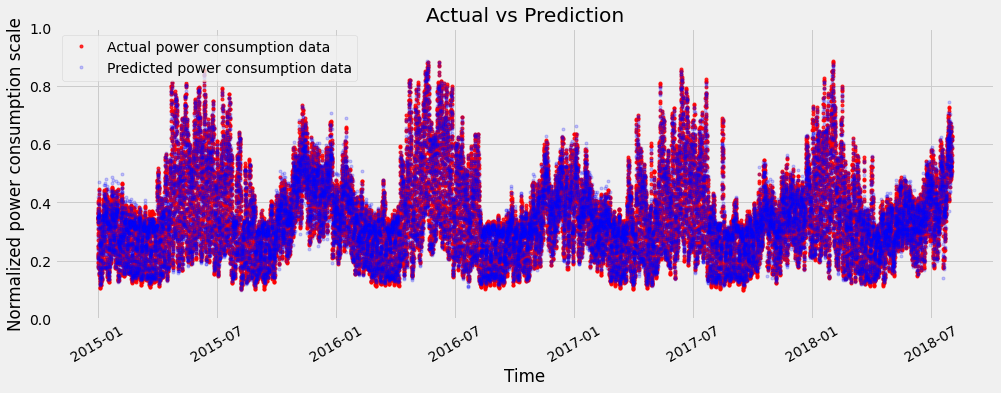

In [ ]:
#Plot hasil prediksi data keseluruhan
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(15,5))
    plt.plot(test, 'r.', alpha=0.8, label='Actual power consumption data')
    plt.plot(predicted[:,0], 'b.', alpha=0.2, label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    x_ticks = np.arange(0, 31419, 4380)
    plt.xticks(range(0, 31419, 4380), ['2015-01', '2015-07', '2016-01', '2016-07', '2017-01', '2017-07', '2018-01', '2018-07' ], rotation=30)
    plt.xticks(x_ticks)
    plt.ylim(0,1)
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "Actual vs Prediction")

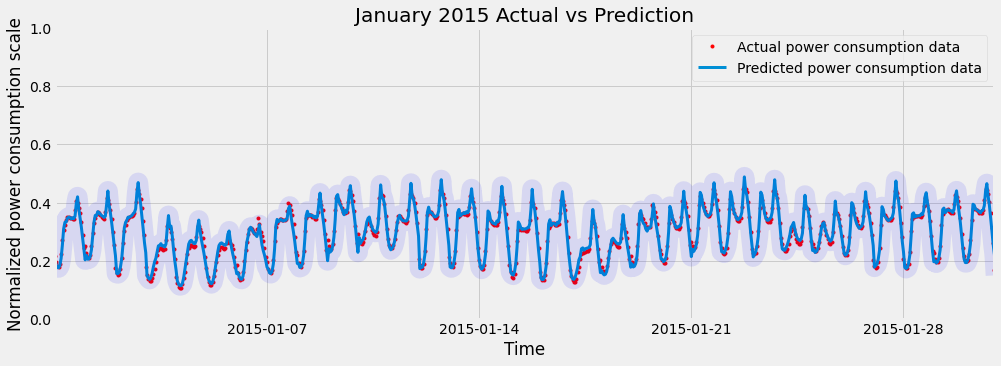

In [ ]:
#Plot hasil prediksi data bulan Januari 2015
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(15,5))
    plt.plot(test, 'r.', linewidth=10, label='Actual power consumption data')
    plt.plot(predicted[:,0], linewidth= 3, label='Predicted power consumption data')
    plt.plot(predicted[:,0], color='b', linewidth= 20, alpha=0.1)
    plt.title(title)
    plt.xlim([0,744])
    plt.ylim([0,1])
    x_ticks = np.arange(0, 750, 168)
    plt.xticks(range(0, 750, 168), ['', '2015-01-07', '2015-01-14', '2015-01-21', '2015-01-28'])
    plt.xticks(x_ticks)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "January 2015 Actual vs Prediction")

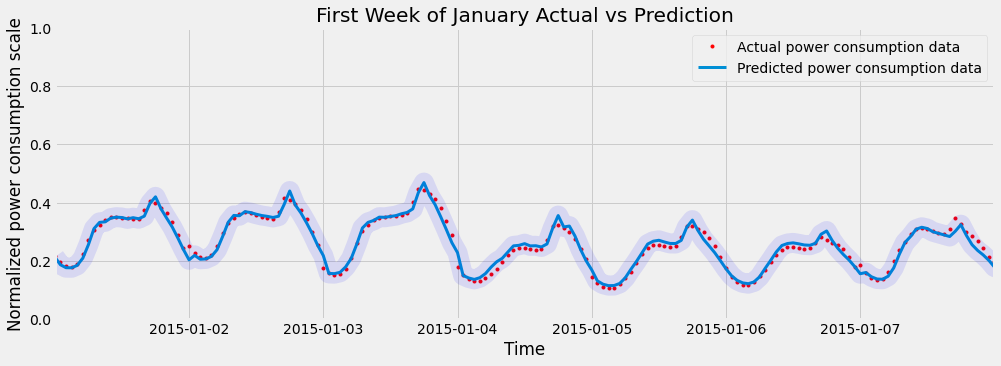

In [ ]:
#Plot hasil prediksi data minggu pertama bulan Januari 2015
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(15,5))
    plt.plot(test, 'r.', linewidth=10, label='Actual power consumption data')
    plt.plot(predicted[:,0], linewidth= 3, label='Predicted power consumption data')
    plt.plot(predicted[:,0], color='b', linewidth= 20, alpha=0.1)
    plt.title(title)
    plt.xlim([0,168])
    plt.ylim([0,1])
    x_ticks = np.arange(0, 169, 24)
    plt.xticks(range(0, 169, 24), ['', '2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05', '2015-01-06', '2015-01-07', ''])
    plt.xticks(x_ticks)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
    
plot_predictions(y_test, lstm_predictions, "First Week of January Actual vs Prediction")

In [ ]:
#Menentukan nilai MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=y_test,
                   y_pred=lstm_predictions.transpose())

4.041174831570714